# PHAS0030 Assignment Week 7

This assignment explores the modelling of particles in a box. The particles are assigned a position with minimum (0) entropy by placing them in a lattice grid. Then, each particle is assigned a random velocity, and the simulation is progressed through time. Observations were then made of the mean square distance of the particles from their starting position, given by the formula

$$ D(t)=\frac{1}{N}\sum_{i=1}^{N}\left(\mathbf{r}_i(t)-\mathbf{r}_i(0)\right)^2.$$

Appropriate formulae and functions were adapted from the Session 7 in-class exercises.

In [2]:
# Appropriate imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import integrate

### 1. Set up the force function

This function was adapted from the class exercises. It includes the Lennard-Jones potential, a potential which is repulsive at short distances due to the Pauli repulsion felt by the overlaping electron clouds, and attractive at long distances due to the van der Waals interaction. The formula is given by

$$ V(r)=4\epsilon\left[\left(\frac{\sigma}{r}\right)^{12}-\left(\frac{\sigma}{r}\right)^6\right] $$

where $ \epsilon$ and $\sigma$ are constants, and the first and second terms approximate the repulsive and attractive forces respectively. 

In [95]:
def find_forces_LJ(pos,N,sigma,epsilon,boxlen):
    """
    Calculates the energy and force due to a Lennard-Jones potential

    Inputs:
    pos              3-dimensional position vector
    N                Number of particles
    sigma, epsilon   LJ parameters

    Outputs:
    energy           Energy of the particle
    force            Force experienced by the particle
    """
    force = np.zeros((N,3))
    energy = 0.0
    for i in range(N-1):
        for j in range(i+1,N):
            dr = pos[j] - pos[i]
            dr -= boxlen*np.rint(dr/boxlen)
            dr2 = np.sum(dr*dr)
            dr2i = 1.0/dr2
            dr6i = dr2i**3
            fij= 24.0*epsilon*dr*dr2i*dr6i*(sigma**6 - 2.0*sigma**12*dr6i)
            force[i] += fij
            force[j] -= fij
            energy += 4.0*epsilon*dr6i*(sigma**12*dr6i - sigma**6)
    return energy, force

### 2. Set up the lattice and the simulation parameters



In [96]:
# Initialising constants
Nsteps = 10000
kB = 1.38e-23         # J/K
sigma = 0.275e-9      # 0.275nm
epsilon = 36*kB       # 36kT
mass = 20.2*1.673e-27 # kg

# Creating lattice
Ncells = 4
boxlen = 1.1 * 2**(1/6) * sigma * Ncells
Npart = Ncells**3
rbox3 = np.zeros([Nsteps,Npart,3])
vbox3 = np.zeros([Nsteps,Npart,3])
count = 0

for i in range(Ncells):
    for j in range(Ncells):
        for k in range(Ncells):
            rbox3[0,count] = (1.0/Ncells)*boxlen*np.array([i,j,k])
            count += 1

Text(0.5, 0, 'z')

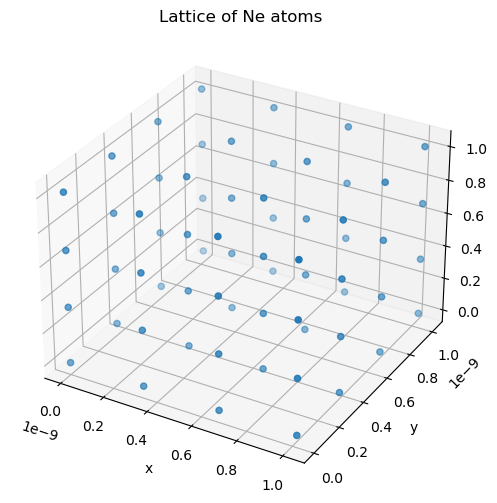

In [97]:
# Plot
fig_3d5 = plt.figure(figsize=(10,6))
ax3d5 = fig_3d5.add_subplot(111,projection='3d')
ax3d5.scatter(rbox3[0,:,0],rbox3[0,:,1],rbox3[0,:,2])
ax3d5.set_title('Lattice of Ne atoms')
ax3d5.set_xlabel('x')
ax3d5.set_ylabel('y')
ax3d5.set_zlabel('z')

### 3. Initialise velocities

In [98]:
# Initialise velocities
initT  = 50          # K
# The initial distribution can have an arbitrary scaling
rng = np.random.default_rng()
vbox3[0] = rng.standard_normal(size=(Npart,3))
# Rescales the velocities
v_scale = np.sqrt(3*Npart*kB*initT/(mass*np.sum(vbox3[0]*vbox3[0])))
vbox3[0] *= v_scale
energy = np.zeros(Nsteps)
temp = np.zeros(Nsteps)
e, f = find_forces_LJ(vbox3[0], Npart, sigma, epsilon, boxlen)
energy[0] = e
temp[0] = mass*np.sum(vbox3[0]*vbox3[0])/(3*Npart*kB)
acc = f/mass
dt = 1e-15 # s 
MSD = np.zeros(Nsteps-1)

### 4. Run simulation


In [99]:
def pbc(r,boxlen):
    """Implements periodic boundary conditions for a particle"""
    return np.mod(r,boxlen)

for step in range(1,Nsteps):
    rbox3[step] = rbox3[step-1] + dt*vbox3[step-1] + 0.5*dt*dt*acc # acc at step-1
    # Periodic boundaries
    rbox3[step] = pbc(rbox3[step],boxlen)

    energy[step], f = find_forces_LJ(rbox3[step],Npart,sigma,epsilon,boxlen)
    acc_next = f/mass
    vbox3[step] = vbox3[step-1] + 0.5*dt*(acc_next + acc)
    temp[step] = mass*np.sum(vbox3[step]*vbox3[step])/(3*Npart*kB)
    acc = acc_next
    # Calculate mean-squared displacement
    MSD[step-1] = np.sum(
        np.linalg.norm(rbox3[step-1]-rbox3[0])**2
        )
    

MSD /= (3*Npart)

Text(0, 0.5, 'Mean Squared Displacement (m$^2$)')

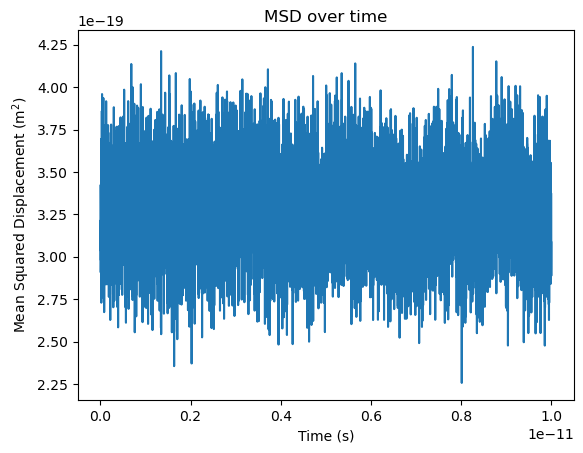

In [100]:
time = dt*np.arange(1,Nsteps)
plt.plot(time[1:],MSD[1:])
plt.title('MSD over time')
plt.xlabel('Time (s)')
plt.ylabel(r'Mean Squared Displacement (m$^2$)')

Text(0, 0.5, 'MSD/6t (m$^2$/s)')

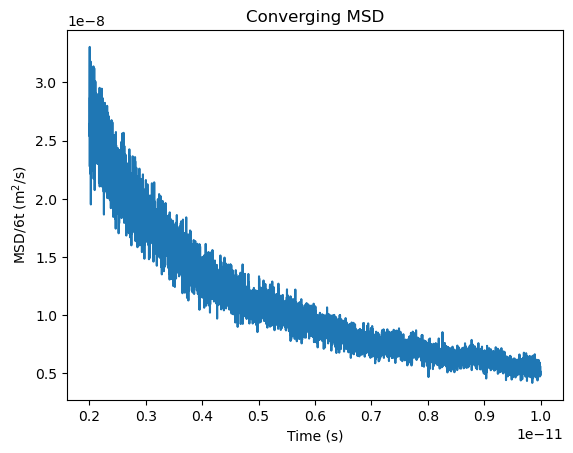

In [101]:
plt.plot(time[2000:], MSD[2000:]/(6*time[2000:]))
plt.title('Converging MSD')
plt.xlabel('Time (s)')
plt.ylabel(r'MSD/6t (m$^2$/s)')


### 5. Calculate the integral

Here, the function 

$$ I(t)=\frac{1}{3N}\int_{0}^{t}\sum_{i=1}^{N}\mathbf{v}_i(t)\cdot\mathbf{v}_i(0)dt $$

is calculated from the quantities above and plotted against time.

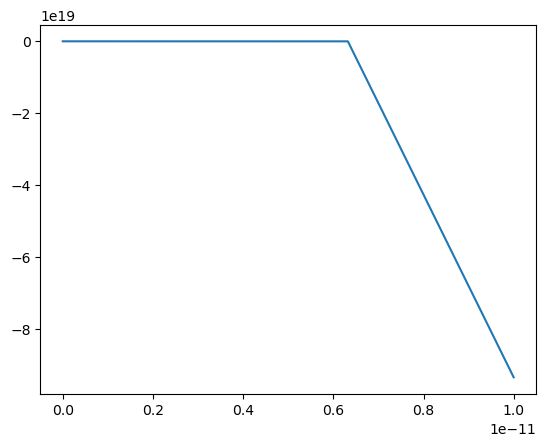

In [106]:
Int = np.zeros(Nsteps)
for step in range(1,Nsteps):
    Int[step] = Int[step-1] + np.sum(vbox3[step] * vbox3[0])

Int*= (dt/(3*Npart))

plt.plot(time, Int[:-1])

## Conclusion
In conclusion, since the integral did not converge on a value unlike $D(t)/t$, a conclusion cannot be made about the former.